# Akantu Tutorial: Fracture simulation with cohesive elements
	
The main goal of this tutorial is to model a crack propagation with extrinsic cohesive elements.
The problem can be summarized using the following schematic:

![](schematic.svg)

# Import the necessary modules

In [2]:
# import akantu
import akantu as aka
#import numpy for vector manipulation
import numpy as np
# import the pyplot submodule to draw figures
import matplotlib.pyplot as plt
# import triangluation routine to plot meshes
import matplotlib.tri as tri
# setting a default image size large enough
plt.rcParams['figure.figsize'] = [10, 10]
# for progress bars
from tqdm import tqdm
# for progress bars
import tools

## Solving a sharp crack tip problem with linear elasticity

### Setting up the geometry

The above problem is modelled with the *BRep* representation in the GMsh format as follows. 
Please read and understand geoemtric details. Report your observations. 

The file *plate.geo* is:

In [2]:
geometry_file = """
h1 = .1;
h2 = .5;
L = 10;
l = L/20.;
Point(1) = {0, 0, 0, h1};
Point(2) = {L, 0, 0, h1};
Point(3) = {L, L, 0, h2};
Point(4) = {0, L, 0, h2};
Point(5) = {l, 0, 0, h1};

Point(6) =  {0, 0, 0, h1};
Point(7) =  {L, -L, 0, h2};
Point(8) =  {0, -L, 0, h2};


Line(1) = {1, 5};
Line(2) = {4, 1};
Line(3) = {3, 4};
Line(4) = {2, 3};
Line(5) = {5, 2};

Line Loop(1) = {2, 3, 4, 5, 1};
Plane Surface(1) = {1};

Line(6) =  {5, 6};
Line(7) =  {6, 8};
Line(8) =  {8, 7};
Line(9) =  {7, 2};
Line Loop(2) = {6, 7, 8, 9, -5};
Plane Surface(2) = {2};


Physical Surface(8) = {1,2};
Physical Line("left") = {2,7};
Physical Line("bottom") = {8};
Physical Line("top") = {3};
Physical Line("right") = {4,9};

"""

with open('plate.geo', 'w') as f:
    f.write(geometry_file)

import subprocess
ret = subprocess.run("gmsh -2 -order 1 -o plate.msh plate.geo", shell=True)
if ret.returncode:
    print("Beware, gmsh could not run: mesh is not regenerated")
else:
    print("Mesh generated")

Info    : Running 'gmsh -2 -order 1 -o plate.msh plate.geo' [Gmsh 4.8.4, 1 node, max. 1 thread]
Info    : Started on Wed May 17 18:48:31 2023
Info    : Reading 'plate.geo'...
Info    : Done reading 'plate.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 60%] Meshing curve 6 (Line)
Info    : [ 70%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.0163067s, CPU 0.01629s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.088418s, CPU 0.084619s)
Info    : 5072 nodes 10245 elements
Info    : Writing 'plate.msh'...
Info    : Done writing 'plate.msh'
Info    : Stopped on Wed May 17 18:48:31

### Setting up the constitutive law

At first we will resolve the above problem with small deformation linear-elasticity. To do so, we prepare the **Akantu**'s material file.

In [3]:
material_file = """
material elastic [
    name = virtual
    rho = 1    # density
    E   = 1    # young's modulus
    nu  = 0.3  # poisson's ratio
    finite_deformation = false
]
"""

with open('material.dat', 'w') as f:
    f.write(material_file)

### Setting up the *SolidMechanicsModel *

Now the **Akantu** model will be created

In [4]:
# reading material file
aka.parseInput('material.dat')

# creating mesh
spatial_dimension = 2
mesh = aka.Mesh(spatial_dimension)
mesh.read('plate.msh')

# creating the model
model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._static)

# configure the solver
solver = model.getNonLinearSolver('static')
solver.set('max_iterations', 100)
solver.set('threshold', 1e-10)
solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

The mesh can be looked at (with matplotlib for instance) to check everything went fine

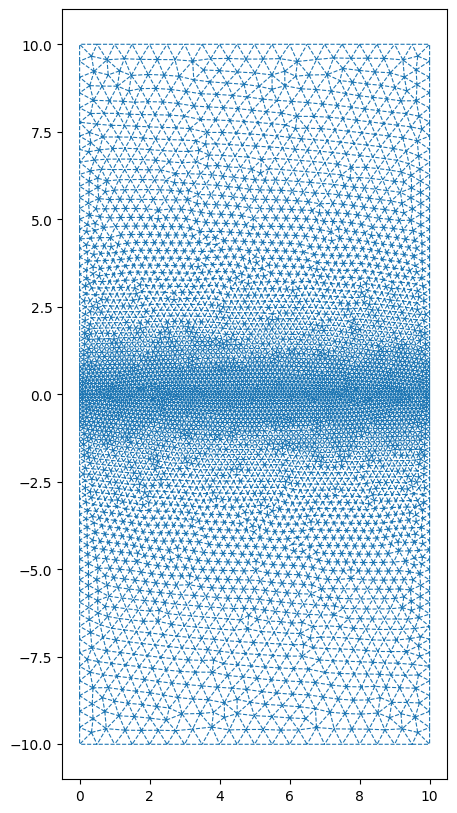

In [5]:
mesh = model.getMesh()
conn = mesh.getConnectivity(aka._triangle_3)
nodes = mesh.getNodes()
triangles = tri.Triangulation(nodes[:, 0], nodes[:, 1], conn)

plt.axes().set_aspect('equal')
t = plt.triplot(triangles, '--', lw=.8)

### Set the boundary conditions

In [6]:
# Dirichlet
model.applyBC(aka.FixedValue(0., aka._x), 'left')
model.applyBC(aka.FixedValue(0., aka._y), 'bottom')

# Neumann Traction
traction = np.zeros(spatial_dimension)
F = 0.095
traction[int(aka._y)] = F
model.getExternalForce()[:] = 0
model.applyBC(aka.FromSameDim(traction), 'top')

### Solve the problem and analyse the result

In [7]:
# solve
model.solveStep()

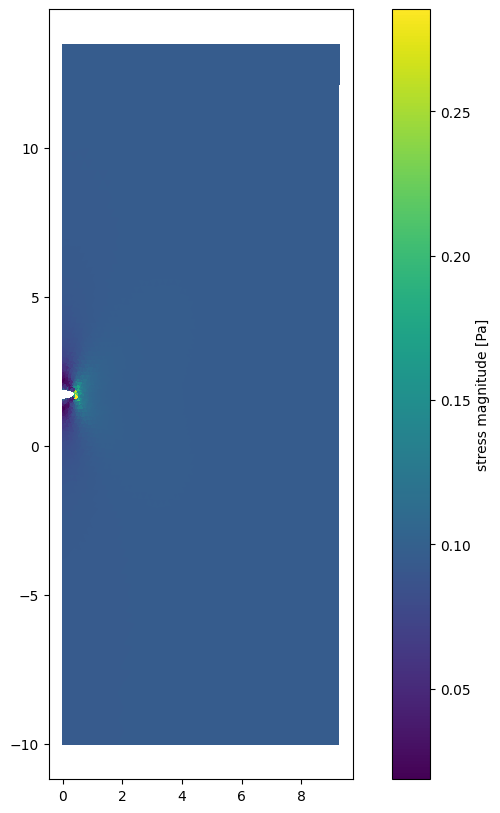

In [8]:
plt.axes().set_aspect('equal')
# plot the stress field on mesh with magnified displacements
u = model.getDisplacement()
magnified_triangles = tri.Triangulation(nodes[:, 0]+u[:,0]*2, nodes[:, 1]+u[:,1]*2, conn)
# t = plt.triplot(magnified_triangles, lw=0.3)
stress_field = model.getMaterial(0).getStress(aka._triangle_3)
stress_disp = plt.tripcolor(magnified_triangles, np.linalg.norm(stress_field, axis=1))
cbar = plt.colorbar(stress_disp)
cbar.set_label('stress magnitude [Pa]')

## Regularization of the problem with cohesive element insertion
	
In order the employ cohesive-zone modeling in **Akantu** with dynamical insersion, several changes must be made.

### Setting up the cohesive constitutive law

Please observe the changes to the material file:

In [9]:
material_file = """
model solid_mechanics_model_cohesive [
  cohesive_inserter [
    bounding_box = [[0,10],[-10, 10]]
  ]


  material elastic [
    name = virtual
    rho = 1    # density
    E   = 1    # young's modulus
    nu  = 0.3  # poisson's ratio
    finite_deformation = true
  ]

  material cohesive_linear [
    name = cohesive
    sigma_c = 0.1
    G_c = 1e-2
    beta = 1.
    penalty = 10.
  ]
]
"""

with open('material.dat', 'w') as f:
    f.write(material_file)

There are new blocks in the material file:

1. cohesive_inserter: constrols where cohesive elements are allowed to be inserted
2. cohesive_linear: provides constitutive parameters for a linear cohesive law.

### Setting up the *SolidMechanicsModelCohesive*

We need to read again the material file and the mesh

In [10]:
# reading material file
aka.parseInput('material.dat')
# creating mesh
spatial_dimension = 2
mesh = aka.Mesh(spatial_dimension)
mesh.read('plate.msh')

Then another model, capable of introducing cohesive elements, is necessary:

In [11]:
model = aka.SolidMechanicsModelCohesive(mesh)
model.initFull(_analysis_method=aka._static, _is_extrinsic=True)

# configures the static solver
solver = model.getNonLinearSolver('static')
solver.set('max_iterations', 100)
solver.set('threshold', 1e-10)
solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

# Initilize a new solver (explicit Newmark with lumped mass)
model.initNewSolver(aka._explicit_lumped_mass)
# Dynamic insertion of cohesive elements
model.updateAutomaticInsertion()

### Generate paraview files

In [12]:
# Initialization for bulk vizualisation
model.setBaseName('plate')
model.addDumpFieldVector('displacement')
model.addDumpFieldVector('velocity')
model.addDumpFieldVector('external_force')
model.addDumpField('strain')
model.addDumpField('stress')
model.addDumpField('blocked_dofs')

# Initialization of vizualisation for Cohesive model
model.setBaseNameToDumper('cohesive elements', 'cohesive')
model.addDumpFieldVectorToDumper('cohesive elements', 'displacement')
model.addDumpFieldToDumper('cohesive elements', 'damage')
model.addDumpFieldVectorToDumper('cohesive elements', 'tractions')
model.addDumpFieldVectorToDumper('cohesive elements', 'opening')

### Setting the boundary conditions

In [13]:
# Dirichlet
model.applyBC(aka.FixedValue(0., aka._x), 'left')
model.applyBC(aka.FixedValue(0., aka._y), 'bottom')

# Neumann Traction
traction = np.zeros(spatial_dimension)
traction[int(aka._y)] = F
model.getExternalForce()[:] = 0
model.applyBC(aka.FromSameDim(traction), 'top')

### Static resolution

In [14]:
model.solveStep('static')
# model.dump()
# model.dump('cohesive elements')

### Damped dynamics resolution

The resolution of the regularized problem is made with 1000 explicit steps, during which the velocity is damped to dissipate kinetic energy and to reach static equilibrium. 

In [15]:
# choose the timestep
model.setTimeStep(model.getStableTimeStep()*0.1)
# set maximum number of iteration
maxsteps = 1000
# solve
for i in tqdm(range(0, maxsteps)):
    model.checkCohesiveStress()
    model.solveStep('explicit_lumped')
    # Velocity damping
    model.getVelocity()[:] *= .9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 220.49it/s]


In [16]:
# new nodes have been inserted: the mesh must be re-constructed
mesh = model.getMesh()
conn = mesh.getConnectivity(aka._triangle_3)
nodes = mesh.getNodes()

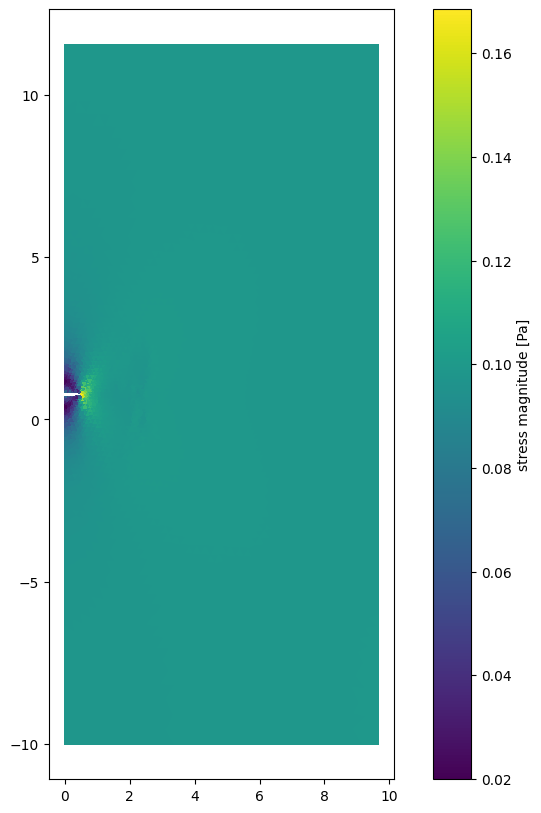

In [17]:
plt.axes().set_aspect('equal')
# plot the stress field on mesh with magnified displacements
u = model.getDisplacement()
magnified_triangles = tri.Triangulation(nodes[:, 0]+u[:,0], nodes[:, 1]+u[:,1], conn)
# t = plt.triplot(magnified_triangles, lw=0.3)
stress_field = model.getMaterial(0).getStress(aka._triangle_3)
stress_disp = plt.tripcolor(magnified_triangles, np.linalg.norm(stress_field, axis=1))
cbar = plt.colorbar(stress_disp)
cbar.set_label('stress magnitude [Pa]')

# Vizualizing the paraview files

Of course *Paraview* would be the preferred way to vizualize the output files. However, from the notebook it is possible to use *pyvista* to scrutinize quickly the results.

In [18]:
# ask to produce paraview files
model.dump()
model.dump('cohesive elements')

In [19]:
import pyvista as pv
import solidipes.viewer_backends

p = pv.Plotter()
plate_mesh = pv.read('paraview/plate_0000.pvtu')
cohesive_mesh = pv.read('paraview/cohesive_0000.pvtu')
plate_warped = plate_mesh.warp_by_vector('displacement')
cohesive_warped = cohesive_mesh.warp_by_vector('displacement')
cohesive_warped.set_active_scalars("damage")
cohesive_threshed = cohesive_warped.threshold([0., 0.99])
p.add_mesh(plate_warped, scalars='velocity')
p.add_mesh(cohesive_threshed, scalars='damage')
v = p.show()
display(plate_mesh)
display(cohesive_mesh)

Widget(value="<iframe src='http://localhost:36859/index.html?ui=P_0x7f457650feb0_0&reconnect=auto' style='widt…

UnstructuredGrid (0x7f454f65a8c0)
  N Cells:    9928
  N Points:   5506
  X Bounds:   0.000e+00, 1.000e+01
  Y Bounds:   -1.000e+01, 1.000e+01
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   6

UnstructuredGrid (0x7f454f65a920)
  N Cells:    475
  N Points:   5506
  X Bounds:   0.000e+00, 1.000e+01
  Y Bounds:   -1.000e+01, 1.000e+01
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   4

## Dynamic propagation

The actual displacement of the top boundary will now be made fixed to the elastic solution. This will allow the dynamical crack propagation to arrest after the consumption of the elastic energy.

In [20]:
# creating mesh
spatial_dimension = 2
mesh = aka.Mesh(spatial_dimension)
mesh.read('plate.msh')

# creates the model
model = aka.SolidMechanicsModelCohesive(mesh)
model.initFull(_analysis_method=aka._static, _is_extrinsic=True)

# configures the static solver
solver = model.getNonLinearSolver('static')
solver.set('max_iterations', 100)
solver.set('threshold', 1e-10)
solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

# Initilize a new solver (explicit Newmark with lumped mass)
model.initNewSolver(aka._explicit_lumped_mass)
# Dynamic insertion of cohesive elements
model.updateAutomaticInsertion()

# Dirichlet
model.applyBC(aka.FixedValue(0., aka._x), 'left')
model.applyBC(aka.FixedValue(0., aka._y), 'bottom')

# Neumann Traction
traction = np.zeros(spatial_dimension)
traction[int(aka._y)] = F
model.getExternalForce()[:] = 0
model.applyBC(aka.FromSameDim(traction), 'top')

# static solve
model.solveStep('static')

### Fixing the displacement to the elastic solution

Then the boundary condition of the top boundary is held fixed at its position, and the applied tractions are removed. For this we can use a specific boundary functor:

In [21]:
# clears external forces
model.getExternalForce()[:] = 0
# fix displacements of the top boundary
model.applyBC(aka.IncrementValue(0, aka._y), 'top')

### Generate paraview files

In [22]:
# Initialization for bulk vizualisation
model.setBaseName('plate')
model.addDumpFieldVector('displacement')
model.addDumpFieldVector('velocity')
model.addDumpFieldVector('external_force')
model.addDumpField('strain')
model.addDumpField('stress')
model.addDumpField('blocked_dofs')

# Initialization of vizualisation for Cohesive model
model.setBaseNameToDumper('cohesive elements', 'cohesive')
model.addDumpFieldVectorToDumper('cohesive elements', 'displacement')
model.addDumpFieldToDumper('cohesive elements', 'damage')
model.addDumpFieldVectorToDumper('cohesive elements', 'tractions')
model.addDumpFieldVectorToDumper('cohesive elements', 'opening')

### Run the dynamical simulation

In [23]:
# choose the timestep
model.setTimeStep(model.getStableTimeStep()*0.1)
# set maximum number of iteration
maxsteps = 10000
# solve
for i in tqdm(range(0, maxsteps)):
    if i % 100 == 0:
        model.dump()
        model.dump('cohesive elements')
    model.checkCohesiveStress()
    model.solveStep('explicit_lumped')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:49<00:00, 91.59it/s]


In [3]:
def get_frame(pv_files, step, plotter, camera, **kwargs):
    plotter.background_color = 'white'
    plate_mesh = pv_files['plate']
    cohesive_mesh = pv_files['cohesive']
    plate_warped = plate_mesh.warp_by_vector('displacement')
    plate_warped.set_active_scalars("velocity")
    cohesive_warped = cohesive_mesh.warp_by_vector('displacement')
    cohesive_warped.set_active_scalars("damage")
    cohesive_threshed = cohesive_warped.threshold([0., 0.9])
    plotter.add_mesh(plate_warped, scalars='stress', show_scalar_bar=True, clim=[0., 0.1], scalar_bar_args={'color': 'black'})
    contours = False
    if contours:
        vel_contours = plate_warped.contour(np.linspace(0.0025, 0.05, 5))
        if vel_contours.GetNumberOfPoints():
            p.add_mesh(vel_contours)
    if cohesive_threshed.GetNumberOfPoints():
        plotter.add_mesh(cohesive_threshed, scalars='damage', show_edges=True, show_scalar_bar=False)
        
    if camera is None:
        plotter.view_xy()
        plotter.camera.zoom(1) 
        
tools.make_video(["plate", "cohesive"], get_frame, framerate=10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]
